# Off-peak analysis

We first read the CSV files that were exported from merging traffic and demand data. Two files are produced, one for actual times (without cancelled trips) and one for planned time (larger file).

In [22]:
import pandas as pd

# Read the CSV file
df_onboard_planned = pd.read_csv('df_onboard_planned.csv')
df_onboard_actual = pd.read_csv('df_onboard_actual.csv') ## NOT used in the analysis!

We want to study passenger punctuality using different metrics during off-peak time period of the day (9-15).

## Filtering data (oustide off-peak)

Let us first filter out the observations outside middday off-peak hours. We remove all trains that first departure outside these hours.

In [23]:
# Define the time range in terms of 'dep_t_float'
earliest_time = 9 * 4  # 9 AM, 36
latest_time = 15 * 4   # 3 PM, 60

# Step 1: Group the data by 'Datum', 'Taguppdrag', 'Tagnr'
grouped_actual = df_onboard_actual.groupby(['Datum', 'Taguppdrag', 'Tagnr'])
grouped_planned = df_onboard_planned.groupby(['Datum', 'Taguppdrag', 'Tagnr'])

# Step 2: Filter out groups based on the first departure time
def filter_by_departure_time(group):
    # Get the first departure's dep_t_float value
    first_dep = group[group['UppehallstypAvgang'] == 'Första']['dep_t_float']
    
    # Check if the first departure exists and is within the specified range
    if not first_dep.empty:
        first_dep_time = first_dep.iloc[0]
        return earliest_time <= first_dep_time <= latest_time
    
    # If no 'Första' is found, exclude the group
    return False

# Step 3: Filter the original DataFrame to keep only the groups that match the condition
df_onboard_actual_offpeak = grouped_actual.filter(filter_by_departure_time).reset_index(drop=True)
df_onboard_planned_offpeak = grouped_planned.filter(filter_by_departure_time).reset_index(drop=True)

In [24]:
# # Step 1: Group the data by 'Datum', 'Taguppdrag', 'Tagnr'
# grouped = df_onboard_planned_offpeak.groupby(['Datum', 'Taguppdrag', 'Tagnr'])

# # Step 2: Identify groups where any 'Ankomsttid' or 'Avgangstid' is missing
# groups_with_missing_values = grouped.filter(lambda group: group[['Ankomsttid', 'Avgangstid']].isnull().any().any())

# # Step 3: Remove those groups from the original DataFrame
# df_onboard_planned_offpeak = df_onboard_planned_offpeak[~df_onboard_planned_offpeak.index.isin(groups_with_missing_values.index)]

# # Step 5: Reset index if needed
# df_onboard_planned_offpeak = df_onboard_planned_offpeak.reset_index(drop=True)

### Average train ridership per direction

Let us plot the average train ridership between consecutive station per direction.

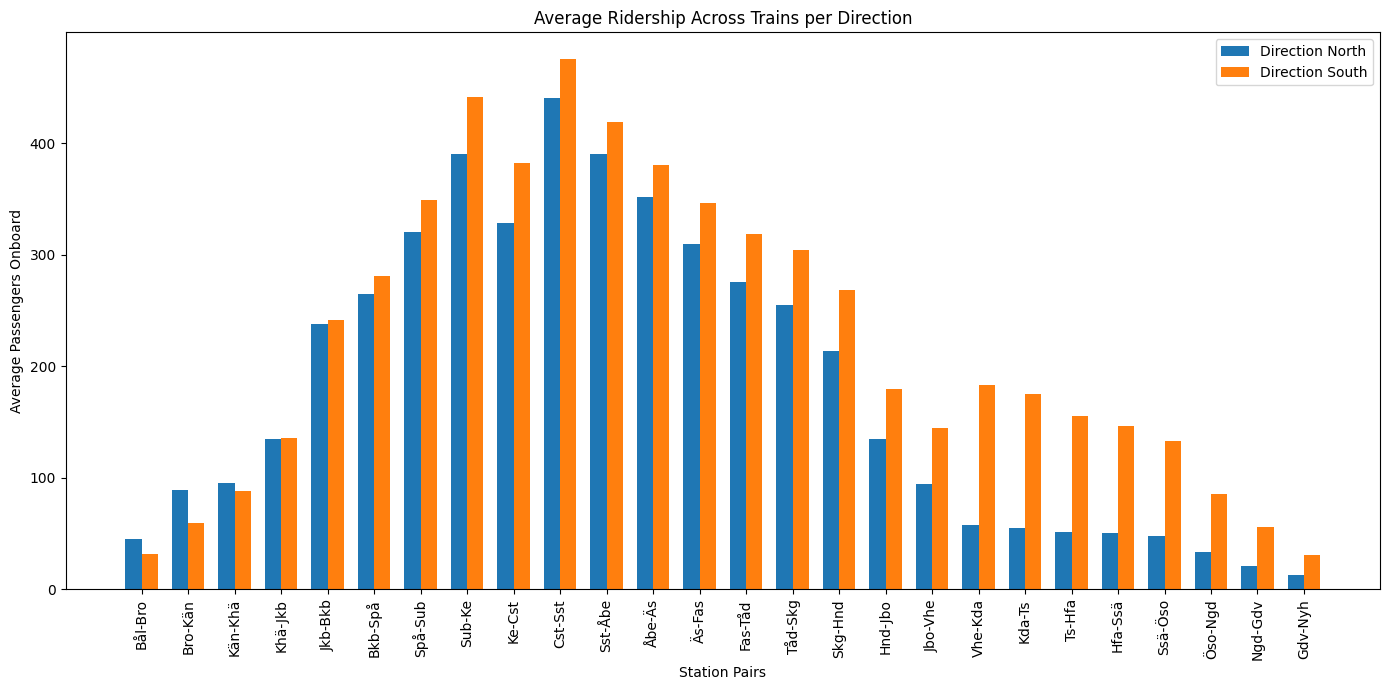

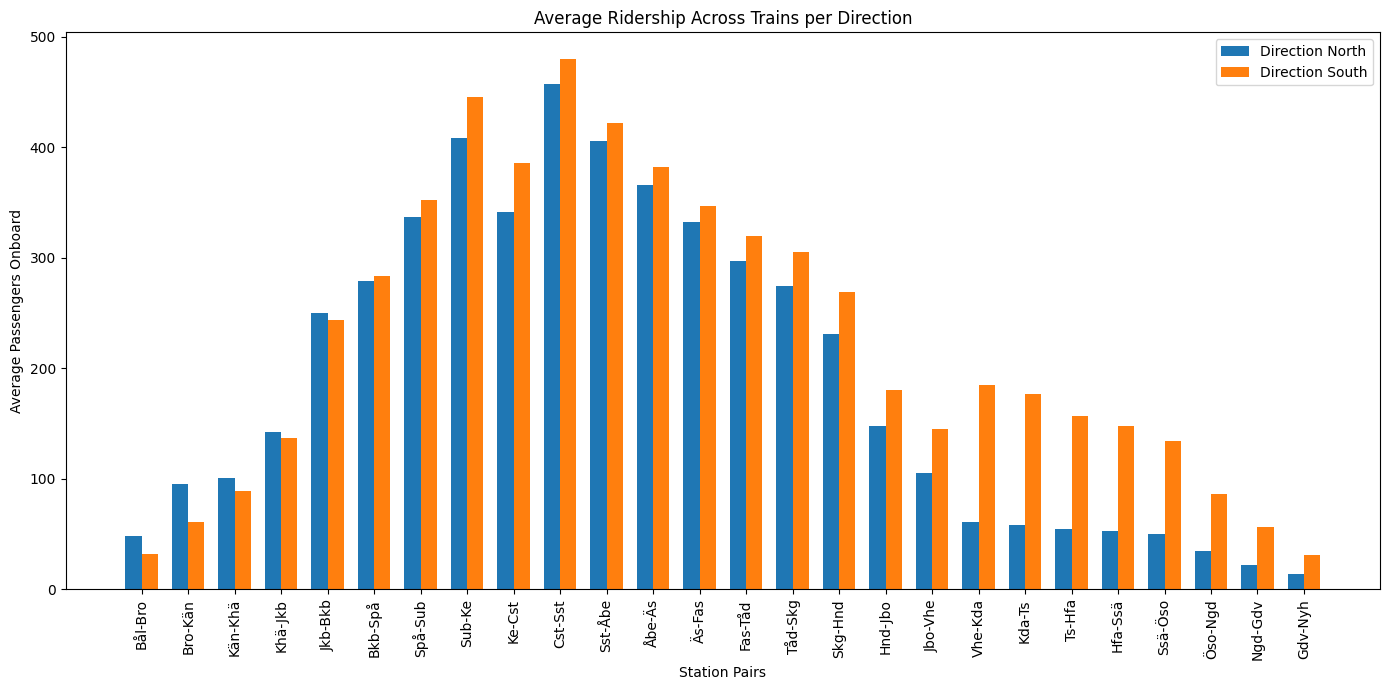

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def plot_ridership(df):
    # List of stations from north to south
    stations_north_to_south = ['Bål', 'Bro', 'Kän', 'Khä', 'Jkb', 'Bkb', 'Spå', 'Sub', 'Ke', 'Cst', 'Sst', 'Åbe', 'Äs',
                            'Fas', 'Tåd', 'Skg', 'Hnd', 'Jbo', 'Vhe', 'Kda', 'Ts', 'Hfa', 'Ssä', 'Öso', 'Ngd', 'Gdv', 'Nyh']

    # Step 1: Create pairs of consecutive stations
    station_pairs_north_to_south = [(stations_north_to_south[i], stations_north_to_south[i+1]) for i in range(len(stations_north_to_south) - 1)]
    station_pairs_south_to_north = [(to, from_) for from_, to in station_pairs_north_to_south]

    # Combine the two sets of pairs into a DataFrame
    station_pairs_df = pd.DataFrame({
        'pair_north_to_south': [f"{from_}-{to}" for from_, to in station_pairs_north_to_south],
        'pair_south_to_north': [f"{from_}-{to}" for from_, to in station_pairs_south_to_north]
    })

    # Step 2: Group by direction and pairs of consecutive stations
    df_grouped = df.groupby(['direction', 'Fran_platssignatur', 'Till_platssignatur'])['n_onboard'].mean().reset_index()

    # Step 3: Assign pairs and filter by valid pairs
    df_grouped['pair'] = df_grouped.apply(
        lambda row: f"{row['Fran_platssignatur']}-{row['Till_platssignatur']}" 
        if row['direction'] == -1 else f"{row['Till_platssignatur']}-{row['Fran_platssignatur']}", axis=1
    )

    # Filter valid pairs
    valid_pairs = station_pairs_df['pair_north_to_south'].tolist() + station_pairs_df['pair_south_to_north'].tolist()
    df_grouped_filtered = df_grouped[df_grouped['pair'].isin(valid_pairs)].copy()

    # Step 4: Order by the station pairs for the x-axis
    df_grouped_filtered['pair_order'] = pd.Categorical(df_grouped_filtered['pair'], 
                                                    categories=station_pairs_df['pair_north_to_south'].tolist() + station_pairs_df['pair_south_to_north'].tolist(), 
                                                    ordered=True)
    df_grouped_filtered = df_grouped_filtered.sort_values('pair_order')

    # Step 5: Prepare data for the bar chart
    northbound_data = df_grouped_filtered[df_grouped_filtered['direction'] == 1].set_index('pair_order')['n_onboard']
    southbound_data = df_grouped_filtered[df_grouped_filtered['direction'] == -1].set_index('pair_order')['n_onboard']

    # Ensure all pairs are included for both directions (fill with 0 if missing)
    northbound_data = northbound_data.reindex(station_pairs_df['pair_south_to_north'].tolist(), fill_value=0)
    southbound_data = southbound_data.reindex(station_pairs_df['pair_south_to_north'].tolist(), fill_value=0)

    # Step 6: Plot the bar chart
    bar_width = 0.35
    index = np.arange(len(station_pairs_df['pair_north_to_south']))

    plt.figure(figsize=(14, 7))
    plt.bar(index, northbound_data, bar_width, label='Direction North')
    plt.bar(index + bar_width, southbound_data, bar_width, label='Direction South')

    plt.xticks(index + bar_width / 2, station_pairs_df['pair_north_to_south'].tolist(), rotation=90)
    plt.xlabel('Station Pairs')
    plt.ylabel('Average Passengers Onboard')
    plt.title('Average Ridership Across Trains per Direction')
    plt.legend()
    plt.tight_layout()

    plt.show()
plot_ridership(df_onboard_planned_offpeak)
plot_ridership(df_onboard_actual_offpeak)

### Calculating travel time distributions

We have among others the following information, i.e., 'Taguppdrag', 'Tagnr', 'Datum', 'UppehallstypAvgang', 'UppehallstypAnkomst', 'Delstrackanummer', 'Fran_platssignatur', 'Till_platssignatur', 'Ankomsttid', 'Avgangstid', 'Planerad_ankomsttid', 'Planerad_avgangstid', 'dep_delay', 'arr_delay', 'dep_t_float', 'arr_t_float', 'dep_delay_minutes', 'arr_delay_minutes', 'direction', 'n_onboard', 'n_boarding', 'n_alighting', 'n_alighting_next.


We also have columns with station signature with information on the number of passengers boarding towards these stations.


We want to find the travel time distributions between every pair of stations in the studied line.
For each direction (+1 or -1), we will go over every train (identified by 'Taguppdrag', 'Tagnr', 'Datum') and all the stations in order (of Delstrackanummer). We will fill in a dataframe with for each train, the following columns: from_station, to_station, Number passengers traveling between these stations, and the planned travel time (Planerad_ankomsttid to to_station - Planerad_avgangstid from from_station), and the actual travel time similarly but Ankomsttid - Avgangstid.

In [26]:
import pandas as pd

# Initialize the DataFrame to store results
columns = ['Taguppdrag', 'Tagnr', 'Datum', 'direction', 'from_station', 'to_station',
           'n_passengers', 'planned_travel_time', 'actual_travel_time']
df_travel_times = pd.DataFrame(columns=columns)

# List of stations from south to north
stations_south_to_north = ['Bål', 'Bro', 'Kän', 'Khä', 'Jkb', 'Bkb', 'Spå', 'Sub', 'Ke', 'Cst', 'Sst', 'Åbe', 'Äs',
                           'Fas', 'Tåd', 'Skg', 'Hnd', 'Jbo', 'Vhe', 'Kda', 'Ts', 'Hfa', 'Ssä', 'Öso', 'Ngd', 'Gdv', 'Nyh']

# Convert relevant columns to datetime
df_onboard_planned_offpeak['Planerad_ankomsttid'] = pd.to_datetime(df_onboard_planned_offpeak['Planerad_ankomsttid'], errors='coerce')
df_onboard_planned_offpeak['Planerad_avgangstid'] = pd.to_datetime(df_onboard_planned_offpeak['Planerad_avgangstid'], errors='coerce')
df_onboard_planned_offpeak['Ankomsttid'] = pd.to_datetime(df_onboard_planned_offpeak['Ankomsttid'], errors='coerce')
df_onboard_planned_offpeak['Avgangstid'] = pd.to_datetime(df_onboard_planned_offpeak['Avgangstid'], errors='coerce')

# Split the dataframe into northbound and southbound data
df_planned_northbound = df_onboard_planned_offpeak[df_onboard_planned_offpeak['direction'] == 1]
df_planned_southbound = df_onboard_planned_offpeak[df_onboard_planned_offpeak['direction'] == -1]

We do the same thing for dataframe from actual times.

In [27]:
# Convert relevant columns to datetime
df_onboard_actual_offpeak['Planerad_ankomsttid'] = pd.to_datetime(df_onboard_actual_offpeak['Planerad_ankomsttid'], errors='coerce')
df_onboard_actual_offpeak['Planerad_avgangstid'] = pd.to_datetime(df_onboard_actual_offpeak['Planerad_avgangstid'], errors='coerce')
df_onboard_actual_offpeak['Ankomsttid'] = pd.to_datetime(df_onboard_actual_offpeak['Ankomsttid'], errors='coerce')
df_onboard_actual_offpeak['Avgangstid'] = pd.to_datetime(df_onboard_actual_offpeak['Avgangstid'], errors='coerce')

# Split the dataframe into northbound and southbound data
df_actual_northbound = df_onboard_actual_offpeak[df_onboard_actual_offpeak['direction'] == 1]
df_actual_southbound = df_onboard_actual_offpeak[df_onboard_actual_offpeak['direction'] == -1]

In [28]:
def process_direction(df, planned_or_actual):
    grouped_trains = df.groupby(['Taguppdrag', 'Tagnr', 'Datum', 'direction'])

    df_travel_times_list = []

    for train_id, train_data in grouped_trains:
        train_data_sorted = train_data.sort_values(by='Delstrackanummer')

        # Pre-extract necessary columns
        fran_signatures = train_data_sorted['Fran_platssignatur'].values
        till_signatures = train_data_sorted['Till_platssignatur'].values
        if planned_or_actual == 'planned':
            arrival_times = train_data_sorted['Planerad_ankomsttid'].values
            departure_times = train_data_sorted['Planerad_avgangstid'].values
        else: # actual times
            arrival_times = train_data_sorted['Ankomsttid'].values
            departure_times = train_data_sorted['Avgangstid'].values

        # Use NumPy arrays to store row data for efficiency
        rows_list = []

        # Iterate over stations
        for i in range(len(train_data_sorted)):
            curr_from_station = fran_signatures[i]

            # Use slicing to avoid nested loop
            next_to_stations = till_signatures[i:]
            passengers_to_next = train_data_sorted.iloc[i:]['n_onboard'].values
            durations = (arrival_times[i:] - departure_times[i]).astype('timedelta64[m]').astype(int)

            # Construct rows
            for j in range(len(next_to_stations)):
                rows_list.append((
                    train_id[0], train_id[1], train_id[2], train_id[3], 
                    curr_from_station, next_to_stations[j], 
                    passengers_to_next[j], durations[j]
                ))

        df_train = pd.DataFrame(rows_list, columns=[
            'Taguppdrag', 'Tagnr', 'Datum', 'direction',
            'Fran_platssignatur', 'Till_platssignatur', 'n_passengers',
            planned_or_actual+'_travel_time'
        ])
        
        df_travel_times_list.append(df_train)
    
    return pd.concat(df_travel_times_list, ignore_index=True)

In [29]:
from joblib import Parallel, delayed

# Parallel execution for northbound and southbound data
results_planned = Parallel(n_jobs=2)(delayed(process_direction)(df, 'planned') for df in [df_planned_northbound, df_planned_southbound])
results_actual = Parallel(n_jobs=2)(delayed(process_direction)(df, 'actual') for df in [df_actual_northbound, df_actual_southbound])


# Combine the results
df_travel_times_planned = pd.concat(results_planned, ignore_index=True)
df_travel_times_actual = pd.concat(results_actual, ignore_index=True)

### Plotting travel time distributions

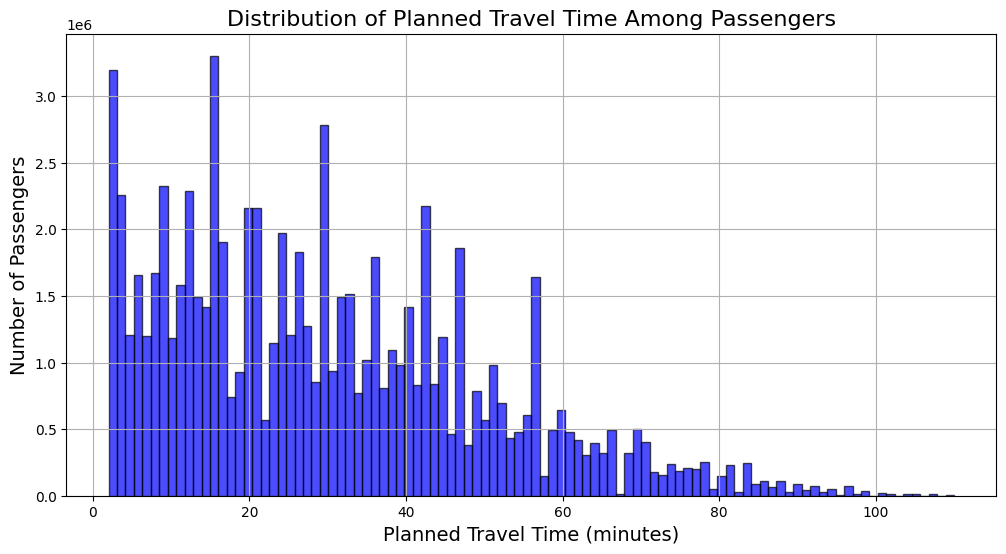

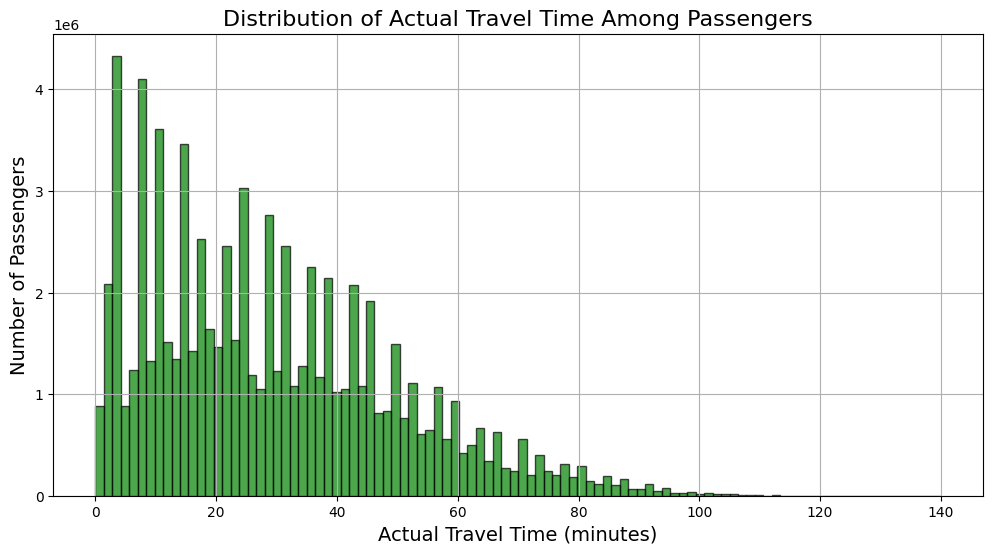

In [33]:
import matplotlib.pyplot as plt

# Plot 1: Distribution of planned travel time among passengers
plt.figure(figsize=(12, 6))

plt.hist(df_travel_times_planned['planned_travel_time'], bins=100, weights=df_travel_times_planned['n_passengers'], alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Planned Travel Time (minutes)', fontsize=14)
plt.ylabel('Number of Passengers', fontsize=14)
plt.title('Distribution of Planned Travel Time Among Passengers', fontsize=16)
plt.grid(True)
plt.show()

# Plot 2: Distribution of actual travel time among passengers
plt.figure(figsize=(12, 6))

plt.hist(df_travel_times_actual['actual_travel_time'], bins=100, weights=df_travel_times_actual['n_passengers'], alpha=0.7, color='green', edgecolor='black')
plt.xlabel('Actual Travel Time (minutes)', fontsize=14)
plt.ylabel('Number of Passengers', fontsize=14)
plt.title('Distribution of Actual Travel Time Among Passengers', fontsize=16)
plt.grid(True)
plt.show()


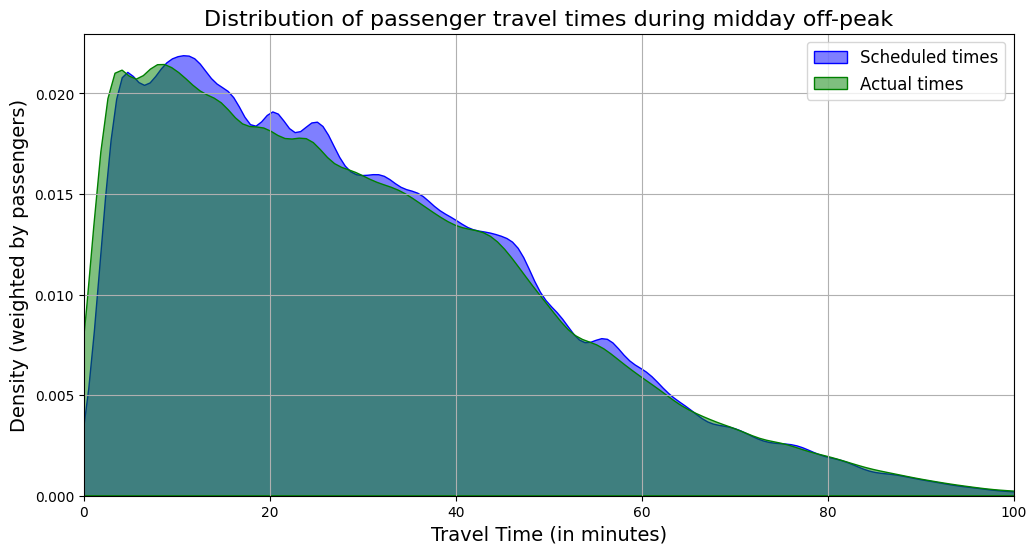

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 6))

# Plot KDE for planned travel time distribution
sns.kdeplot(data=df_travel_times_planned, x='planned_travel_time', weights='n_passengers', color='blue', fill=True, alpha=0.5, label='Scheduled times')

# Plot KDE for actual travel time distribution
sns.kdeplot(data=df_travel_times_actual, x='actual_travel_time', weights='n_passengers', color='green', fill=True, alpha=0.5, label='Actual times')

# Add labels and title
plt.xlabel('Travel Time (in minutes)', fontsize=14)
plt.ylabel('Density (weighted by passengers)', fontsize=14)
plt.title('Distribution of passenger travel times during midday off-peak', fontsize=16)

# Add a legend
plt.legend(loc='upper right', fontsize=12)

# Display the grid
plt.grid(True)

# Set x-axis limits
plt.xlim(0, 100)

# Show the plot
plt.show()


### Travel time percentile

We are going now to study the journey time percentiles. For that we look at one Origin Destination (OD) example and plot the actual travel time percentile on the x-axis and travel time in minutes on the y-axis.
We will also plot the line horizontal line corresponding to the average planned travel time on that OD pair.

In [37]:
# Group by Origin-Destination pairs and sum the number of passengers
od_ridership = df_travel_times_actual.groupby(['Fran_platssignatur', 'Till_platssignatur'])['n_passengers'].sum().reset_index()

# Sort the OD pairs by ridership in descending order
od_ridership_sorted = od_ridership.sort_values(by='n_passengers', ascending=False)

# Get the top two OD pairs with the highest ridership
top_two_od_pairs = od_ridership_sorted.head(2)

# Display the top two OD pairs
print(top_two_od_pairs)


    Fran_platssignatur Till_platssignatur   n_passengers
531                Sub                 Ke  325686.786935
244                Jkb                 Ke  325686.786935


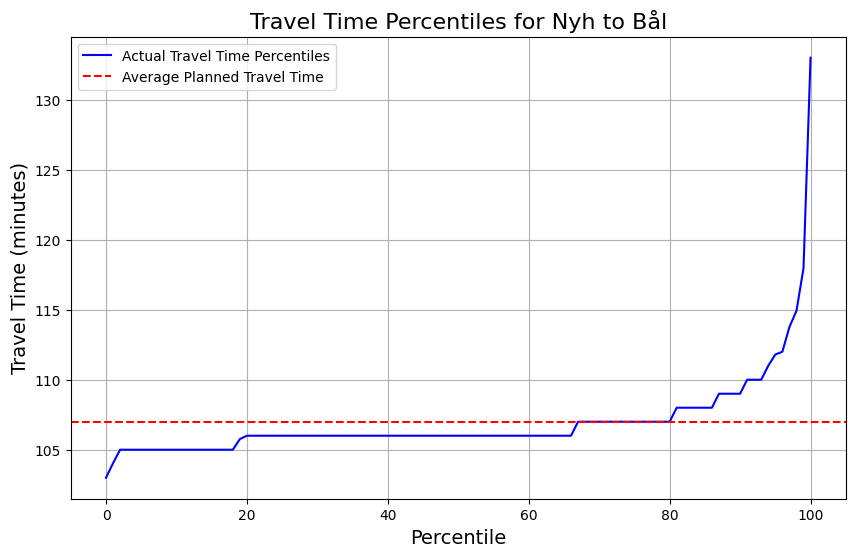

In [36]:
# Select a specific OD pair (replace 'Origin' and 'Destination' with actual station codes)
origin = 'Sub'
destination = 'Ke'

# Filter data for the selected OD pair
df_od_planned = df_travel_times_planned[(df_travel_times_planned['Fran_platssignatur'] == origin) & 
                                        (df_travel_times_planned['Till_platssignatur'] == destination)]
df_od_actual = df_travel_times_actual[(df_travel_times_actual['Fran_platssignatur'] == origin) & 
                                      (df_travel_times_actual['Till_platssignatur'] == destination)]

# Calculate the percentiles of actual travel time
percentiles = np.percentile(df_od_actual['actual_travel_time'], np.arange(0, 101, 1))

# Calculate the average planned travel time
avg_planned_travel_time = df_od_planned['planned_travel_time'].mean()

# Plotting
plt.figure(figsize=(10, 6))

# Plot the percentiles of actual travel time
plt.plot(np.arange(0, 101, 1), percentiles, label='Actual Travel Time Percentiles', color='blue')

# Plot the average planned travel time as a horizontal line
plt.axhline(y=avg_planned_travel_time, color='red', linestyle='--', label='Average Planned Travel Time')

# Add labels and title
plt.xlabel('Percentile', fontsize=14)
plt.ylabel('Travel Time (minutes)', fontsize=14)
plt.title(f'Travel Time Percentiles for {origin} to {destination}', fontsize=16)

# Add legend
plt.legend()

# Show plot
plt.grid(True)
plt.show()
